# INF 552 - Homework 6

In [946]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance

# 1. Supervised, Semi-Supervised, and Unsupervised Learning 

## (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [1140]:
cols = ['ID Number', 'Diagnostic']

# Ten real-valued features are computed for each cell nucleus
features = ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePoint', \
            'Symmetry', 'FractalDimenension']

for n in range(1,4):
    for f in features:
        cols.append(f +'' + str(n))

df = pd.read_csv('wdbc.data', header=None)
df.columns = cols

df = df.replace("B", 0) 
df = df.replace("M", 1)
df['Diagnostic'] = df['Diagnostic'].astype(int)

df.head()

,ID Number,Diagnostic,Radius1,Texture1,Perimeter1,Area1,Smoothness1,Compactness1,Concavity1,ConcavePoint1,Symmetry1,FractalDimenension1,Radius2,Texture2,Perimeter2,Area2,Smoothness2,Compactness2,Concavity2,ConcavePoint2,Symmetry2,FractalDimenension2,Radius3,Texture3,Perimeter3,Area3,Smoothness3,Compactness3,Concavity3,ConcavePoint3,Symmetry3,FractalDimenension3
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## (b) Monte-Carlo Simulation
Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times

In [911]:
column = ['Algorithm', 'Average Accuracy', 'Average Precision', 'Average Recall', 'Average F-Score', 'Average AUC']
metrics_df = pd.DataFrame(columns = column)

### i. Supervised Learning

In [1253]:
# Function to get first 20% of the positive and negative classes as the test set and rest as training
def train_test(df):
    M_df = df[df.Diagnostic == 1]
    B_df = df[df.Diagnostic == 0]

    # Finds 20% of positive and negative class test set
    M_train_df, M_test_df = train_test_split(M_df, test_size = 0.2)
    B_train_df, B_test_df = train_test_split(B_df, test_size = 0.2)
    
    # Concat them together to get entire dataset
    train_df = pd.concat([M_train_df, B_train_df], axis=0)
    test_df = pd.concat([M_test_df, B_test_df], axis=0)
    
    return(train_df, test_df)

In [1254]:
# Function to plot ROC and report confusion matrix
def ROC_confusionMatrix(y_true, y_pred, y_scores):
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    data = [[tp, fn], [fp, tn]]
    confusion_df = pd.DataFrame(data, columns=["Predicted M", "Predicted B"])
    confusion_df = confusion_df.rename(index={0: 'Actual M', 1: 'Actual B'})
    print(confusion_df)
    
    # Plot ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

Iteration 1:
Best Penalty Parameter: {'C': 5.994842503189409}
Train: accuracy = 0.986784, precision = 0.982249, recall = 0.982249, f1 = 0.982249, AUC = 0.985861
Test: accuracy = 0.947826, precision = 0.893617, recall = 0.976744, f1 = 0.933333, AUC = 0.953650


Iteration 2:
Best Penalty Parameter: {'C': 5.994842503189409}
Train: accuracy = 0.991189, precision = 0.994012, recall = 0.982249, f1 = 0.988095, AUC = 0.989370
Test: accuracy = 0.965217, precision = 0.914894, recall = 1.000000, f1 = 0.955556, AUC = 0.972222


Iteration 3:
Best Penalty Parameter: {'C': 5.994842503189409}
Train: accuracy = 0.991189, precision = 0.994012, recall = 0.982249, f1 = 0.988095, AUC = 0.989370
Test: accuracy = 0.956522, precision = 0.952381, recall = 0.930233, f1 = 0.941176, AUC = 0.951227


Iteration 4:
Best Penalty Parameter: {'C': 5.994842503189409}
Train: accuracy = 0.986784, precision = 0.993939, recall = 0.970414, f1 = 0.982036, AUC = 0.983453
Test: accuracy = 0.947826, precision = 1.000000, recall 

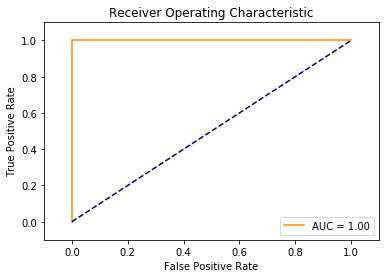


 Confusion matrix and ROC for testing of iteration 30:
          Predicted M  Predicted B
Actual M           42            1
Actual B           25           47


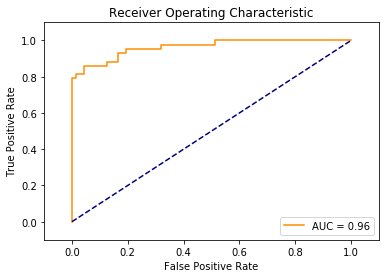

In [1255]:
sup_train_metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1':[], 'auc':[]}
sup_test_metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1':[], 'auc':[]}

for i in range(1,31):
    train_test_df = train_test(df) # Call train test function
    train_df = train_test_df[0]
    test_df = train_test_df[1]
    
    X_train = train_df.iloc[:,2:]
    y_train = train_df.iloc[:,1]
    X_test = test_df.iloc[:,2:]
    y_test = test_df.iloc[:,1]

    # Normalize the data
    min_max_scaler = preprocessing.MinMaxScaler()
    values_scaled = min_max_scaler.fit_transform(X_train.values)
    X_train = pd.DataFrame(values_scaled)
    X_train.columns = cols[2:]

    values_scaled = min_max_scaler.fit_transform(X_test.values)
    X_test = pd.DataFrame(values_scaled)
    X_test.columns = cols[2:]

    # Train an L1-penalized SVM and use CV=5 to choose penalty parameter
    param_grid = {'C': np.logspace(-5, 8, 10)}
    supervised_model = LinearSVC(penalty= 'l1', dual=False, max_iter = 5000)
    grid = GridSearchCV(supervised_model, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)

    # Determine metrics for train and test set
    y_train_pred = grid.predict(X_train)
    y_train_scores = grid.decision_function(X_train)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    sup_train_metrics['accuracy'].append(train_accuracy)
    train_precision = precision_score(y_train, y_train_pred)
    sup_train_metrics['precision'].append(train_precision)
    train_recall = recall_score(y_train, y_train_pred)
    sup_train_metrics['recall'].append(train_recall)
    train_f1 = f1_score(y_train, y_train_pred)
    sup_train_metrics['f1'].append(train_f1)
    train_auc = roc_auc_score(y_train,y_train_pred)
    sup_train_metrics['auc'].append(train_auc)

    print('Iteration %d:' %(i))
    print('Best Penalty Parameter:', grid.best_params_)
    print('Train: accuracy = %f, precision = %f, recall = %f, f1 = %f, AUC = %f'\
          %(train_accuracy, train_precision, train_recall, train_f1, train_auc))

    y_test_pred = grid.predict(X_test)
    y_test_scores = grid.decision_function(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    sup_test_metrics['accuracy'].append(test_accuracy)
    test_precision = precision_score(y_test, y_test_pred)
    sup_test_metrics['precision'].append(test_precision)
    test_recall = recall_score(y_test, y_test_pred)
    sup_test_metrics['recall'].append(test_recall)
    test_f1 = f1_score(y_test, y_test_pred)
    sup_test_metrics['f1'].append(test_f1)
    test_auc = roc_auc_score(y_test, y_test_pred)
    sup_test_metrics['auc'].append(test_auc)

    print('Test: accuracy = %f, precision = %f, recall = %f, f1 = %f, AUC = %f'\
          %(test_accuracy, test_precision, test_recall, test_f1, test_auc))
    print('\n')
    
    if i == 30:
        print('Confusion matrix and ROC for training of iteration 30:')
        ROC_confusionMatrix(y_train, y_train_pred, y_train_scores)
        print('\n Confusion matrix and ROC for testing of iteration 30:')
        ROC_confusionMatrix(y_test, y_test_pred, y_test_scores)

In [1256]:
# Determine average scores for supervised learning
supervised_train = ['Supervised: Train'] + [round(np.mean(i),3) for i in list(sup_train_metrics.values())]
supervised_test = ['Supervised: Test'] + [round(np.mean(i),3) for i in list(sup_test_metrics.values())]
metrics_df.loc[0] = supervised_train
metrics_df.loc[1] = supervised_test

In [1257]:
metrics_df.loc[0:1]

,Algorithm,Average Accuracy,Average Precision,Average Recall,Average F-Score,Average AUC
0,Supervised: Train,0.983,0.991,0.964,0.977,0.979
1,Supervised: Test,0.921,0.862,0.969,0.906,0.930


### ii. Semi-Supervised Learning / Self-training

In [1135]:
def semi_supervised_learning(train_df):
    
    # 50% of pos. class and 50% of neg. class in training set as labeled data and the rest as unlabeled 
    M_label_df, M_unlabel_df = train_test_split(train_df[train_df.Diagnostic == 1], test_size = 0.5)
    B_label_df, B_unlabel_df = train_test_split(train_df[train_df.Diagnostic == 0], test_size = 0.5)

    train_label_df = pd.concat([M_label_df, B_label_df], axis=0)
    train_unlabel_df = pd.concat([M_unlabel_df, B_unlabel_df], axis=0)

    X_train_label = train_label_df.iloc[:,2:]
    y_train_label = train_label_df.iloc[:,1]

    # Train an L1-penalized SVM and use CV = 5 to decide penalty parameters
    param_grid = {'C': np.logspace(-5, 8, 10)}
    semi_model = LinearSVC(penalty= 'l1', dual=False, max_iter = 5000)
    grid = GridSearchCV(semi_model, param_grid=param_grid, cv=5)
    grid.fit(X_train_label, y_train_label)

    while train_unlabel_df.shape[0] != 0:
        # Determine distance from remaining data points in the training set to the hyperplane of the SVM
        train_unlabel_df['Diagnostic'] = grid.predict(train_unlabel_df.iloc[:,2:]) # Predict Label using SVM
        train_unlabel_df['distance'] = np.abs(grid.decision_function(train_unlabel_df.iloc[:, 2:])) # Determine Distance
        train_unlabel_df = train_unlabel_df.sort_values(by=['distance'], ascending=False) 

        selected = train_unlabel_df.iloc[0,:-1].to_frame().transpose() # Datapoint with largest distance
        train_unlabel_df = train_unlabel_df.iloc[1:,:-1]
        train_label_df = pd.concat([train_label_df, selected], axis=0)

        X_train_label = train_label_df.iloc[:,2:]
        y_train_label = train_label_df.iloc[:,1]

        # Retrain SVM
        grid.fit(X_train_label, y_train_label) 
        
    return grid

Iteration 1:
Best Penalty Parameter: {'C': 5.994842503189409}
Train: accuracy = 0.969163, precision = 1.000000, recall = 0.917160, f1 = 0.956790, AUC = 0.958580
Test: accuracy = 0.956522, precision = 0.975000, recall = 0.906977, f1 = 0.939759, AUC = 0.946544


Iteration 2:
Best Penalty Parameter: {'C': 5.994842503189409}
Train: accuracy = 0.969163, precision = 1.000000, recall = 0.917160, f1 = 0.956790, AUC = 0.958580
Test: accuracy = 0.921739, precision = 0.854167, recall = 0.953488, f1 = 0.901099, AUC = 0.928133


Iteration 3:
Best Penalty Parameter: {'C': 5.994842503189409}
Train: accuracy = 0.977974, precision = 0.987730, recall = 0.952663, f1 = 0.969880, AUC = 0.972823
Test: accuracy = 0.886957, precision = 0.767857, recall = 1.000000, f1 = 0.868687, AUC = 0.909722


Iteration 4:
Best Penalty Parameter: {'C': 5.994842503189409}
Train: accuracy = 0.953744, precision = 0.930233, recall = 0.946746, f1 = 0.938416, AUC = 0.952320
Test: accuracy = 0.860870, precision = 0.728814, recall 

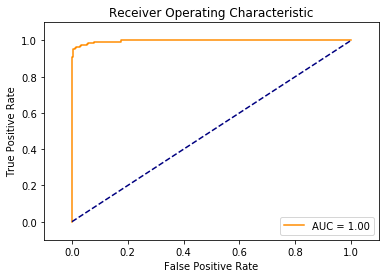


 Confusion matrix and ROC for testing of iteration 30:
          Predicted M  Predicted B
Actual M           39            4
Actual B            3           69


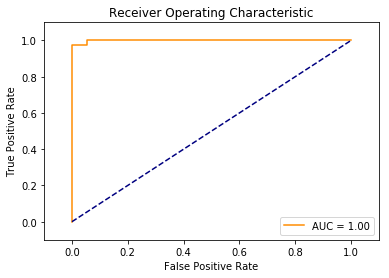

In [1143]:
semi_train_metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1':[], 'auc':[]}
semi_test_metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1':[], 'auc':[]}

for i in range(1,31): 
    train_test_df = train_test(df)
    train_df = train_test_df[0].reset_index(drop=True)
    test_df = train_test_df[1]

    X_train = train_df.iloc[:,2:]
    y_train = train_df.iloc[:,1]
    X_test = test_df.iloc[:,2:]
    y_test = test_df.iloc[:,1]

    # Normalize the data
    min_max_scaler = preprocessing.MinMaxScaler()
    values_scaled = min_max_scaler.fit_transform(X_train.values)
    X_train = pd.DataFrame(values_scaled)
    X_train.columns = cols[2:]

    values_scaled = min_max_scaler.fit_transform(X_test.values)
    X_test = pd.DataFrame(values_scaled)
    X_test.columns = cols[2:]

    # Create training set with scaled X data
    scaled_train_df = X_train.copy()
    scaled_train_df['Diagnostic'] = y_train
    scaled_train_df['ID Number'] = train_df['ID Number']
    
    # Reorder columns to match original train dataset
    scaled_train_df = scaled_train_df.reindex(columns=cols) 

    print('Iteration %d:' %(i))
    # Call function to perform semi-supervised learning
    semi_model = semi_supervised_learning(scaled_train_df) 
    
    # Determine metrics for train and test set
    y_train_pred = semi_model.predict(X_train)
    y_train_scores = grid.decision_function(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    semi_train_metrics['accuracy'].append(train_accuracy)
    train_precision = precision_score(y_train, y_train_pred)
    semi_train_metrics['precision'].append(train_precision)
    train_recall = recall_score(y_train, y_train_pred)
    semi_train_metrics['recall'].append(train_recall)
    train_f1 = f1_score(y_train, y_train_pred)
    semi_train_metrics['f1'].append(train_f1)
    train_auc = roc_auc_score(y_train,y_train_pred)
    semi_train_metrics['auc'].append(train_auc)
    
    print('Best Penalty Parameter:', grid.best_params_)
    print('Train: accuracy = %f, precision = %f, recall = %f, f1 = %f, AUC = %f'\
            %(train_accuracy, train_precision, train_recall, train_f1, train_auc))


    y_test_pred = semi_model.predict(X_test)
    y_test_scores = grid.decision_function(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    semi_test_metrics['accuracy'].append(test_accuracy)
    test_precision = precision_score(y_test, y_test_pred)
    semi_test_metrics['precision'].append(test_precision)
    test_recall = recall_score(y_test, y_test_pred)
    semi_test_metrics['recall'].append(test_recall)
    test_f1 = f1_score(y_test, y_test_pred)
    semi_test_metrics['f1'].append(test_f1)
    test_auc = roc_auc_score(y_test, y_test_pred)
    semi_test_metrics['auc'].append(test_auc)

    print('Test: accuracy = %f, precision = %f, recall = %f, f1 = %f, AUC = %f'\
        %(test_accuracy, test_precision, test_recall, test_f1, test_auc))
    print('\n')

    if i == 30:
        print('Confusion matrix and ROC for training of iteration 30:')
        ROC_confusionMatrix(y_train, y_train_pred, y_train_scores)
        print('\n Confusion matrix and ROC for testing of iteration 30:')
        ROC_confusionMatrix(y_test, y_test_pred, y_test_scores)

In [1250]:
# Determine average scores for semi-supervised learning
semi_train = ['Semi-Supervised: Train'] + [round(np.mean(i),3) for i in list(semi_train_metrics.values())]
semi_test = ['Semi-Supervised: Test'] + [round(np.mean(i),3) for i in list(semi_test_metrics.values())]
metrics_df.loc[2] = semi_train
metrics_df.loc[3] = semi_test

In [1251]:
metrics_df.loc[2:3]

,Algorithm,Average Accuracy,Average Precision,Average Recall,Average F-Score,Average AUC
2,Semi-Supervised: Train,0.978,0.98,0.960,0.970,0.974
3,Semi-Supervised: Test,0.902,0.85,0.943,0.884,0.910


### iii. Unsupervised Learning (K-Means)

A common way to ensure that the algorithm is not trapped at local minimum is to run K-means multiple times and chose the run that gives the lowest area. In KMeans library, the default number of times the k-means algorithm will be run with different centroid seeds is 10, but I have increased it to 100 by setting n_init = 100. According to the documentation for KMeans, the final results will be the best output of n_init consecutive runs in terms of inertia. If we run it k^n times and choosing the best out of those, we would be guaranteed to find the global minimum, but that would be really time consuming. Therefore, increasing n_init can help avoiding falling into local minimum.

https://stackoverflow.com/questions/43789602/avoiding-local-minima-when-using-kmeans

In [791]:
# Functions to determine distance of point from each cluster center
def dst_cluster_1(row):
    return distance.euclidean(kmeans.cluster_centers_[0], row.iloc[2:].tolist())

def dst_cluster_2(row):
    return distance.euclidean(kmeans.cluster_centers_[1], row.iloc[2:-1].tolist())

In [ ]:
# Function to plot ROC and report confusion matrix
def ROC_confusionMatrix_Cluster(y_true, y_pred):
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    data = [[tp, fn], [fp, tn]]
    confusion_df = pd.DataFrame(data, columns=["Predicted M", "Predicted B"])
    confusion_df = confusion_df.rename(index={0: 'Actual M', 1: 'Actual B'})
    print(confusion_df)
    
    # Plot ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

Iteration 1:
Train: accuracy = 0.850220, precision = 0.990291, recall = 0.603550, f1 = 0.750000, AUC = 0.800021
Test: accuracy = 0.878261, precision = 1.000000, recall = 0.674419, f1 = 0.805556, AUC = 0.837209


Iteration 2:
Train: accuracy = 0.845815, precision = 0.990099, recall = 0.591716, f1 = 0.740741, AUC = 0.794104
Test: accuracy = 0.834783, precision = 1.000000, recall = 0.558140, f1 = 0.716418, AUC = 0.779070


Iteration 3:
Train: accuracy = 0.856828, precision = 0.990566, recall = 0.621302, f1 = 0.763636, AUC = 0.808897
Test: accuracy = 0.834783, precision = 1.000000, recall = 0.558140, f1 = 0.716418, AUC = 0.779070


Iteration 4:
Train: accuracy = 0.854626, precision = 0.990476, recall = 0.615385, f1 = 0.759124, AUC = 0.805938
Test: accuracy = 0.834783, precision = 1.000000, recall = 0.558140, f1 = 0.716418, AUC = 0.779070


Iteration 5:
Train: accuracy = 0.848018, precision = 0.990196, recall = 0.597633, f1 = 0.745387, AUC = 0.797062
Test: accuracy = 0.852174, precision = 1

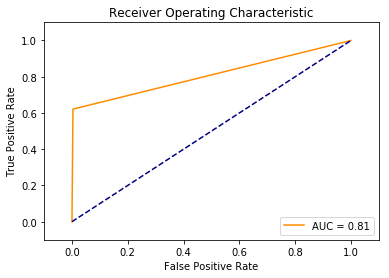


 Confusion matrix and ROC for testing of iteration 30:
          Predicted M  Predicted B
Actual M           25           18
Actual B            0           72


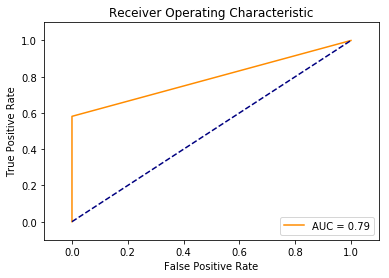

In [797]:
unsup_train_metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1':[], 'auc':[]}
unsup_test_metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1':[], 'auc':[]}

for i in range(1,31):
    train_test_df = train_test(df)
    train_df = train_test_df[0]
    test_df = train_test_df[1]
    
    # k-means algorithm with 2 clusters
    kmeans = KMeans(n_clusters=2,init='random',n_init=100)
    kmeans.fit(train_df.iloc[:,2:])  
    k_labels = kmeans.labels_

    # Determine distance from each point to cluster centroid
    centroid_df = train_df.copy()
    centroid_df['dst_1'] = centroid_df.apply(dst_cluster_1, axis=1)
    centroid_df['dst_2'] = centroid_df.apply(dst_cluster_2, axis=1)

    # Determine of each cluster based on majority poll of true label for 30 closest datapoints
    clabel_1 = centroid_df.sort_values(by='dst_1').iloc[:30, [1]]['Diagnostic'].value_counts().index[0]
    clabel_2 = centroid_df.sort_values(by='dst_2').iloc[:30, [1]]['Diagnostic'].value_counts().index[0]

    # Compare labels provided by k-means with true labels of training data
    cluster_train_df = train_df.copy()
    cluster_train_df['cluster'] = kmeans.labels_
    cluster_train_df['Pred Diagnostic'] = cluster_train_df.apply(lambda x: clabel_1 if x['cluster'] == 0 \
                                                               else clabel_2, axis=1)
    
    # Determine metrics for training set
    y_train = cluster_train_df['Diagnostic']
    y_train_pred = cluster_train_df['Pred Diagnostic']

    train_accuracy = accuracy_score(y_train, y_train_pred)
    unsup_train_metrics['accuracy'].append(train_accuracy)
    train_precision = precision_score(y_train, y_train_pred)
    unsup_train_metrics['precision'].append(train_precision)
    train_recall = recall_score(y_train, y_train_pred)
    unsup_train_metrics['recall'].append(train_recall)
    train_f1 = f1_score(y_train, y_train_pred)
    unsup_train_metrics['f1'].append(train_f1)
    train_auc = roc_auc_score(y_train,y_train_pred)
    unsup_train_metrics['auc'].append(train_auc)

    print('Iteration %d:' %(i))
    print('Train: accuracy = %f, precision = %f, recall = %f, f1 = %f, AUC = %f'\
                %(train_accuracy, train_precision, train_recall, train_f1, train_auc))

    # Determine distance between each test datapoint and cluster centroid
    cluster_test_df = test_df.copy()
    cluster_test_df['dst_1'] = cluster_test_df.apply(dst_cluster_1, axis=1)
    cluster_test_df['dst_2'] = cluster_test_df.apply(dst_cluster_2, axis=1)

    # Classify based on proximity
    cluster_test_df['Pred Diagnostic'] = cluster_test_df.apply(lambda x: clabel_1 if x['dst_1'] < x['dst_2'] \
                                                               else clabel_2, axis=1)
    
    # Determine metrics for test set
    y_test = cluster_test_df['Diagnostic']
    y_test_pred = cluster_test_df['Pred Diagnostic']

    test_accuracy = accuracy_score(y_test, y_test_pred)
    unsup_test_metrics['accuracy'].append(test_accuracy)
    test_precision = precision_score(y_test, y_test_pred)
    unsup_test_metrics['precision'].append(test_precision)
    test_recall = recall_score(y_test, y_test_pred)
    unsup_test_metrics['recall'].append(test_recall)
    test_f1 = f1_score(y_test, y_test_pred)
    unsup_test_metrics['f1'].append(test_f1)
    test_auc = roc_auc_score(y_test, y_test_pred)
    unsup_test_metrics['auc'].append(test_auc)

    print('Test: accuracy = %f, precision = %f, recall = %f, f1 = %f, AUC = %f'\
            %(test_accuracy, test_precision, test_recall, test_f1, test_auc))
    print('\n')

    if i == 30:
        print('Confusion matrix and ROC for training of iteration 30:')
        ROC_confusionMatrix_Cluster(y_train, y_train_pred)
        print('\n Confusion matrix and ROC for testing of iteration 30:')
        ROC_confusionMatrix_Cluster(y_test, y_test_pred)

In [ ]:
# Determine average scores for K-Means
unsupervised_train = ['Unsupervised: Train'] + [round(np.mean(i),3) for i in list(unsup_train_metrics.values())]
unsupervised_test = ['Unsupervised: Test'] + [round(np.mean(i),3) for i in list(unsup_test_metrics.values())]
metrics_df.loc[4] = unsupervised_train
metrics_df.loc[5] = unsupervised_test

In [799]:
metrics_df.loc[4:5]

,Algorithm,Average Accuracy,Average Precision,Average Recall,Average F-Score,Average AUC
4,Unupervised: Train,0.853,0.992,0.611,0.756,0.804
5,Unupervised: Test,0.844,0.995,0.586,0.736,0.792


### iv. Spectral Clustering

In [1027]:
spec_train_metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1':[], 'auc':[]}
spec_test_metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1':[], 'auc':[]}

Iteration 1:
Train: accuracy = 0.850220, precision = 0.971963, recall = 0.615385, f1 = 0.753623, AUC = 0.802429
Test: accuracy = 0.886957, precision = 1.000000, recall = 0.697674, f1 = 0.821918, AUC = 0.848837


Iteration 2:
Train: accuracy = 0.859031, precision = 0.990654, recall = 0.627219, f1 = 0.768116, AUC = 0.811855
Test: accuracy = 0.886957, precision = 1.000000, recall = 0.697674, f1 = 0.821918, AUC = 0.848837


Iteration 3:
Train: accuracy = 0.859031, precision = 0.972973, recall = 0.639053, f1 = 0.771429, AUC = 0.814263
Test: accuracy = 0.886957, precision = 1.000000, recall = 0.697674, f1 = 0.821918, AUC = 0.848837


Iteration 4:
Train: accuracy = 0.876652, precision = 0.974790, recall = 0.686391, f1 = 0.805556, AUC = 0.837932
Test: accuracy = 0.886957, precision = 1.000000, recall = 0.697674, f1 = 0.821918, AUC = 0.848837


Iteration 5:
Train: accuracy = 0.861233, precision = 0.990741, recall = 0.633136, f1 = 0.772563, AUC = 0.814814
Test: accuracy = 0.886957, precision = 1

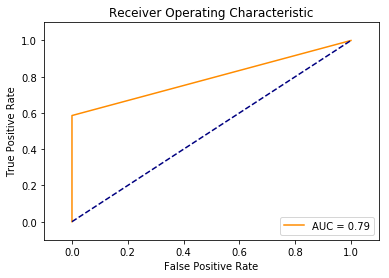


 Confusion matrix and ROC for testing of iteration 30:
          Predicted M  Predicted B
Actual M           30           13
Actual B            0           72


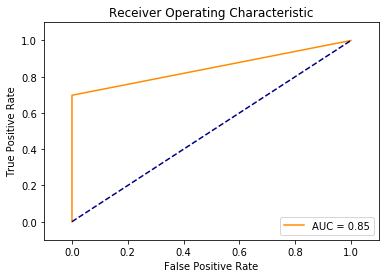

In [1028]:
for i in range(1,31):   
    train_test_df = train_test(df)
    train_df = train_test_df[0]
    test_df = train_test_df[1]

    # Normalize the data
    min_max_scaler = preprocessing.MinMaxScaler()
    values_scaled = min_max_scaler.fit_transform(train_df.iloc[:,2:].values)
    X_train = pd.DataFrame(values_scaled)
    X_train.columns = cols[2:]
    
    values_scaled = min_max_scaler.fit_transform(test_df.iloc[:,2:].values)
    X_test = pd.DataFrame(values_scaled)
    X_test.columns = cols[2:]

    # Use 2 clusters and n_init=100 similar to (b)iii
    spectral = SpectralClustering(n_clusters=2, n_init=100, gamma=1.0, affinity='rbf')
    labels = spectral.fit_predict(X_train)
    
    # Determine which cluster each datapoint is in
    spectral_train_df =  train_df.copy()
    spectral_train_df['Cluster'] = labels
    
    # Label datapoints based on majority label of each cluster 
    for c in range (0,2):
        majority = spectral_train_df[spectral_train_df.Cluster == c]['Diagnostic'].value_counts().index[0]
        spectral_train_df.loc[spectral_train_df.Cluster == c, 'Pred Diagnostic'] = majority
    spectral_train_df['Pred Diagnostic'] = spectral_train_df['Pred Diagnostic'].astype(int)
    
    # Determine metrics for training set
    y_train = spectral_train_df['Diagnostic']
    y_train_pred = spectral_train_df['Pred Diagnostic']

    train_accuracy = accuracy_score(y_train, y_train_pred)
    spec_train_metrics['accuracy'].append(train_accuracy)
    train_precision = precision_score(y_train, y_train_pred)
    spec_train_metrics['precision'].append(train_precision)
    train_recall = recall_score(y_train, y_train_pred)
    spec_train_metrics['recall'].append(train_recall)
    train_f1 = f1_score(y_train, y_train_pred)
    spec_train_metrics['f1'].append(train_f1)
    train_auc = roc_auc_score(y_train,y_train_pred)
    spec_train_metrics['auc'].append(train_auc)
    print('Iteration %d:' %(i))
    print('Train: accuracy = %f, precision = %f, recall = %f, f1 = %f, AUC = %f'\
                    %(train_accuracy, train_precision, train_recall, train_f1, train_auc))
    
    # Determine clusters on test data using .fit_predict method
    spectral_test_df =  test_df.copy()
    labels = spectral.fit_predict(X_test)
    spectral_test_df['Cluster'] = labels
    
    # Label based on majority label of each cluster 
    for c in range (0,2):
        majority = spectral_test_df[spectral_test_df.Cluster == c]['Diagnostic'].value_counts().index[0]
        spectral_test_df.loc[spectral_test_df.Cluster == c, 'Pred Diagnostic'] = majority
    spectral_test_df['Pred Diagnostic'] = spectral_test_df['Pred Diagnostic'].astype(int)
    
    # Determine metrics for test set
    y_train = spectral_train_df['Diagnostic']
    y_train_pred = spectral_train_df['Pred Diagnostic']
    
    spectral_test_df['Pred Diagnostic'] = test_pred

    y_test = spectral_test_df['Diagnostic']
    y_test_pred = spectral_test_df['Pred Diagnostic']

    test_accuracy = accuracy_score(y_test, y_test_pred)
    spec_test_metrics['accuracy'].append(test_accuracy)
    test_precision = precision_score(y_test, y_test_pred)
    spec_test_metrics['precision'].append(test_precision)
    test_recall = recall_score(y_test, y_test_pred)
    spec_test_metrics['recall'].append(test_recall)
    test_f1 = f1_score(y_test, y_test_pred)
    spec_test_metrics['f1'].append(test_f1)
    test_auc = roc_auc_score(y_test, y_test_pred)
    spec_test_metrics['auc'].append(test_auc)

    print('Test: accuracy = %f, precision = %f, recall = %f, f1 = %f, AUC = %f'\
                %(test_accuracy, test_precision, test_recall, test_f1, test_auc))
    print('\n')
    
    if i == 30:
        print('Confusion matrix and ROC for training of iteration 30:')
        ROC_confusionMatrix_Cluster(y_train, y_train_pred)
        print('\n Confusion matrix and ROC for testing of iteration 30:')
        ROC_confusionMatrix_Cluster(y_test, y_test_pred)

In [1029]:
# Determine average scores for spectral clustering
spectral_train = ['Spectral Clustering: Train'] + [round(np.mean(i),3) for i in list(spec_train_metrics.values())]
spectral_test = ['Spectral Clustering: Test'] + [round(np.mean(i),3) for i in list(spec_test_metrics.values())]
metrics_df.loc[6] = spectral_train
metrics_df.loc[7] = spectral_test

In [1030]:
metrics_df.loc[6:7]

,Algorithm,Average Accuracy,Average Precision,Average Recall,Average F-Score,Average AUC
6,Spectral Clustering: Train,0.861,0.983,0.637,0.773,0.815
7,Spectral Clustering: Test,0.887,1.000,0.698,0.822,0.849


### v. Compare the results you obtained by those methods

In [1258]:
metrics_df

,Algorithm,Average Accuracy,Average Precision,Average Recall,Average F-Score,Average AUC
0,Supervised: Train,0.983,0.991,0.964,0.977,0.979
1,Supervised: Test,0.921,0.862,0.969,0.906,0.930
2,Semi-Supervised: Train,0.978,0.980,0.960,0.970,0.974
3,Semi-Supervised: Test,0.902,0.850,0.943,0.884,0.910
4,Unupervised: Train,0.853,0.992,0.611,0.756,0.804
5,Unupervised: Test,0.844,0.995,0.586,0.736,0.792
6,Spectral Clustering: Train,0.861,0.983,0.637,0.773,0.815
7,Spectral Clustering: Test,0.887,1.000,0.698,0.822,0.849


Based on the table above, both train and test set for supervised learning performed the best among four different algorithms. Semi-supervised learning performed better than the unsupervised methods, but not as good as supervised. However, I was surprised to see that it performed almost as well as supervised learning for both train and test. As expected, both unsupervised learning methods (K-means and Spectral Clsutering) performed approximately the same, but were worse compared to supervised and semi-supervised learning. 

## 2. Active Learning Using Support Vector Machines


### (a) Download the banknote authentication Data Set

In [1100]:
cols = ['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Class']
df = pd.read_csv('data_banknote_authentication.txt', header=None)
df.columns = cols
df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [1101]:
train_df, test_df = train_test_split(df, test_size = 472)
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

### (b) Repeat each of the following two procedures 50 times.

### i. Implement Passive Learning

In [1124]:
num_cols = list(range(10,910,10))
passive_df = pd.DataFrame(columns=num_cols)

for i in range(1,51):
    size_remaining = 900
    cols = ['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Class']
    selected_df = pd.DataFrame(columns=cols)
    
    # Set remaining equal to train_df
    remaining = train_df

    passive_errors = []

    while size_remaining != 0:

         # Randomly select 10 datapoints from the remaining set  
        if remaining.shape[0] == 10: # If only 10 points remaining, select those 10
            selected_df = pd.concat([selected_df, remaining], axis=0)
            size_remaining = 0
        else:
            remaining_temp, selected_temp = train_test_split(remaining, test_size=10)
            
            # If first selection where size of training set is only 10 points, make sure there is at least 2 datapoints 
            # from each class to prevent model from unable to being run since all datapoints are from same class
            if remaining_temp.shape[0] == 890:
                while (selected_temp[selected_temp.Class == 0].shape[0] <= 2) or (selected_temp[selected_temp.Class == 1].shape[0] <= 2):
                    remaining_temp, selected_temp = train_test_split(remaining, test_size=10)
                    
            remaining = remaining_temp
            selected = selected_temp
            selected_df = pd.concat([selected_df, selected], axis=0)
            size_remaining = remaining.shape[0]
            
        X_train = selected_df.iloc[:,:-1]
        y_train = selected_df.iloc[:,-1]
        y_train = y_train.astype('int')

        # Train a SVM with linear kernel and L1 Peanlty
        param_grid = {'C': np.logspace(-5, 8, 10)}
        passive_model = LinearSVC(penalty= 'l1', dual=False, max_iter = 5000)
        
        # Set CV to 5 if training set size is 10 since cannot perform CV = 10
        if selected_df.shape[0] == 10:        
            CV = 5
        else:
            CV = 10
        
        grid = GridSearchCV(passive_model, param_grid=param_grid, cv=CV, scoring = 'accuracy')            
        grid.fit(X_train, y_train)

        # Determine error and append to list
        error = 1 - grid.score(X_test, y_test)
        passive_errors.append(error)

    passive_df.loc[i] = passive_errors
    print('Iteration %d:' %(i))
    print(passive_errors)
    print('\n')

Iteration 1:
[0.04661016949152541, 0.03813559322033899, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.012711864406779627, 0.01906779661016944, 0.01906779661016944, 0.016949152542372836, 0.016949152542372836, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.01906779661016944, 0.02330508474576276, 0.025423728813559365, 0.02754237288135597, 0.02754237288135597, 0.02754237288135597, 0.02330508474576276, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.021186440677966156, 0.021186440677966156, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.0169

Iteration 6:
[0.4279661016949152, 0.0402542372881356, 0.02754237288135597, 0.03601694915254239, 0.03601694915254239, 0.03601694915254239, 0.03601694915254239, 0.03601694915254239, 0.03601694915254239, 0.03813559322033899, 0.02754237288135597, 0.02754237288135597, 0.025423728813559365, 0.01906779661016944, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.014830508474576232, 0.014830508474576232, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836

Iteration 11:
[0.13347457627118642, 0.03389830508474578, 0.016949152542372836, 0.016949152542372836, 0.02754237288135597, 0.029661016949152574, 0.02330508474576276, 0.016949152542372836, 0.025423728813559365, 0.029661016949152574, 0.03177966101694918, 0.03177966101694918, 0.0402542372881356, 0.0423728813559322, 0.0423728813559322, 0.0423728813559322, 0.025423728813559365, 0.02330508474576276, 0.025423728813559365, 0.025423728813559365, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.021186440677966156, 0.012711864406779627, 0.012711864406779627, 0.021186440677966156, 0.012711864406779627, 0.012711864406779627, 0.021186440677966156, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.014830508474576232, 0.016949152542372836, 0.01906779661016944, 0.012711864406779627, 0

Iteration 16:
[0.13771186440677963, 0.06144067796610164, 0.05720338983050843, 0.02754237288135597, 0.02330508474576276, 0.03177966101694918, 0.021186440677966156, 0.02330508474576276, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.01906779661016944, 0.016949152542372836, 0.016949152542372836, 0.01906779661016944, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.008474576271186418, 0.01906779661016944, 0.012711864406779627, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.012711864406779627, 0.0105932

Iteration 21:
[0.04661016949152541, 0.048728813559322015, 0.029661016949152574, 0.025423728813559365, 0.025423728813559365, 0.029661016949152574, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.025423728813559365, 0.02330508474576276, 0.014830508474576232, 0.010593220338983023, 0.008474576271186418, 0.025423728813559365, 0.010593220338983023, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.016949152542372836, 0.01694915254

Iteration 26:
[0.2436440677966102, 0.06144067796610164, 0.010593220338983023, 0.01906779661016944, 0.012711864406779627, 0.012711864406779627, 0.01906779661016944, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.016949152542372836, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.014830508474576232, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.01906779661016944, 0.010593220338983023, 0.014830508474576232, 0.014830508474576232, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.014830508474576232, 0.016949152542372836, 0.016

Iteration 31:
[0.4533898305084746, 0.0402542372881356, 0.029661016949152574, 0.0423728813559322, 0.029661016949152574, 0.02330508474576276, 0.029661016949152574, 0.029661016949152574, 0.029661016949152574, 0.021186440677966156, 0.021186440677966156, 0.03177966101694918, 0.014830508474576232, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.025423728813559365, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.016949152542372836, 0.016949152542372836, 0.0

Iteration 36:
[0.17796610169491522, 0.0423728813559322, 0.02330508474576276, 0.03389830508474578, 0.0423728813559322, 0.03813559322033899, 0.0402542372881356, 0.0402542372881356, 0.029661016949152574, 0.029661016949152574, 0.05720338983050843, 0.025423728813559365, 0.029661016949152574, 0.012711864406779627, 0.01906779661016944, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.014830508474576232, 0.02330508474576276, 0.021186440677966156, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.01483050

Iteration 41:
[0.13559322033898302, 0.0423728813559322, 0.03389830508474578, 0.03813559322033899, 0.03389830508474578, 0.03601694915254239, 0.03601694915254239, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.01906779661016944, 0.014830508474576232, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.014830508474576232, 0.016949152542372836, 0.014830508474576232, 0.016949152542372836, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.016949152542372836, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.016949152542372836, 0.016949152542372836, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.012711864406779627, 0.014830508474576232, 0.010593220338983023, 0.010593

Iteration 46:
[0.15889830508474578, 0.05084745762711862, 0.025423728813559365, 0.029661016949152574, 0.025423728813559365, 0.021186440677966156, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.02330508474576276, 0.021186440677966156, 0.021186440677966156, 0.02330508474576276, 0.021186440677966156, 0.025423728813559365, 0.01906779661016944, 0.01906779661016944, 0.02330508474576276, 0.02330508474576276, 0.021186440677966156, 0.02330508474576276, 0.02330508474576276, 0.021186440677966156, 0.021186440677966156, 0.021186440677966156, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 

In [1131]:
print('Passive Learning - Test Errors of Each Iteration for Varying Number of Data Points:')
pd.set_option('display.max_columns', 100)
passive_df

Passive Learning - Test Errors of Each Iteration for Varying Number of Data Points:


,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900
1,0.046610,0.038136,0.025424,0.025424,0.025424,0.025424,0.012712,0.019068,0.019068,0.016949,0.016949,0.012712,0.012712,0.012712,0.012712,0.016949,0.016949,0.016949,0.019068,0.023305,0.025424,0.027542,0.027542,0.027542,0.023305,0.021186,0.021186,0.021186,0.021186,0.021186,0.021186,0.021186,0.021186,0.021186,0.021186,0.021186,0.021186,0.014831,0.014831,0.014831,0.021186,0.021186,0.016949,0.016949,0.016949,0.016949,0.016949,0.016949,0.016949,0.014831,0.014831,0.014831,0.016949,0.014831,0.014831,0.014831,0.014831,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.010593,0.012712,0.012712
2,0.086864,0.084746,0.084746,0.046610,0.021186,0.021186,0.014831,0.012712,0.019068,0.016949,0.021186,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.014831,0.010593,0.010593,0.014831,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.010593,0.010593,0.010593,0.010593,0.010593,0.008475,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712
3,0.063559,0.093220,0.069915,0.036017,0.016949,0.012712,0.019068,0.012712,0.012712,0.021186,0.021186,0.012712,0.012712,0.012712,0.019068,0.014831,0.014831,0.014831,0.014831,0.010593,0.016949,0.010593,0.010593,0.010593,0.010593,0.016949,0.016949,0.016949,0.016949,0.016949,0.016949,0.016949,0.014831,0.014831,0.016949,0.010593,0.016949,0.016949,0.016949,0.010593,0.016949,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.010593,0.010593,0.010593,0.012712,0.010593,0.010593,0.010593,0.012712,0.012712
4,0.044492,0.033898,0.042373,0.025424,0.027542,0.014831,0.014831,0.029661,0.016949,0.021186,0.019068,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.021186,0.014831,0.014831,0.021186,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.016949,0.014831,0.016949,0.016949,0.016949,0.016949,0.016949,0.016949,0.016949,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.016949,0.012712,0.012712,0.014831,0.014831,0.014831,0.014831,0.014831,0.010593,0.014831,0.014831,0.014831,0.014831,0.010593,0.014831,0.014831,0.014831,0.010593,0.014831,0.014831,0.014831,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712
5,0.105932,0.036017,0.036017,0.036017,0.025424,0.027542,0.027542,0.023305,0.025424,0.025424,0.021186,0.021186,0.014831,0.014831,0.014831,0.014831,0.019068,0.014831,0.019068,0.019068,0.019068,0.019068,0.014831,0.014831,0.014831,0.019068,0.014831,0.019068,0.019068,0.019068,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.

### ii. Implement Active Learning

In [1102]:
num_cols = list(range(10,910,10))
active_df = pd.DataFrame(columns=num_cols)

for i in range(1,51):
    active_errors = []
    cols = ['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Class']
    selected_df = pd.DataFrame(columns=cols)
    remaining = train_df
        
    # Randomly select 10 datapoints from training set
    remaining_temp, selected_temp = train_test_split(remaining, test_size=10)
    
    # When training set size = 10, make sure 2 datapoints from each class to prevent to prevent model from unable 
    # to being run since all datapoints are from same class
    while (selected_temp[selected_temp.Class == 0].shape[0] <= 2) or (selected_temp[selected_temp.Class == 1].shape[0] <= 2):
        remaining_temp, selected_temp = train_test_split(remaining, test_size=10)
        
    remaining = remaining_temp
    selected = selected_temp
    
    selected_df = pd.concat([selected_df, selected], axis=0)
    X_train = selected_df.drop(['Class'], axis=1)
    y_train = selected_df['Class']
    y_train = y_train.astype('int')

    param_grid = {'C': np.logspace(-5, 8, 10)}
    active_model = LinearSVC(penalty= 'l1', dual=False, max_iter = 5000)
    
    # When training set size = 10, chose CV = 5 since unable to perform CV = 10
    grid = GridSearchCV(active_model, param_grid=param_grid, cv=5, scoring = 'accuracy')
    grid.fit(X_train, y_train)
    error = 1 - grid.score(X_test,y_test) 
    active_errors.append(error)
    
    
    for n in range(0,89):
        # Determine distance from remaining data points in the training set to the hyperplane of the SVM
        remaining['distance'] = np.abs(grid.decision_function(remaining.iloc[:, :4]))
        remaining = remaining.sort_values(by=['distance']) # Sort by distance
        
        # Chose the 10 closest datapoints to add to training pool
        selected = remaining.iloc[0:10,0:5]
        remaining = remaining.iloc[10:,0:5]

        selected_df = pd.concat([selected_df, selected], axis=0)
        
        X_train = selected_df.drop(['Class'], axis=1)
        y_train = selected_df['Class']
        y_train = y_train.astype('int')

        # Train new SVM using new pool
        param_grid = {'C': np.logspace(-5, 8, 10)}
        active_model = LinearSVC(penalty= 'l1', dual=False, max_iter = 5000)
        
        # Set CV = 10 for the rest of the training set sizes
        grid = GridSearchCV(active_model, param_grid=param_grid, cv=10, scoring = 'accuracy')
        grid.fit(X_train, y_train)
        error = 1 - grid.score(X_test,y_test)
        active_errors.append(error)
        
    active_df.loc[i] = active_errors
    print('Iteration %d:' %(i))
    print(active_errors)
    print('\n')

Iteration 1:
[0.10805084745762716, 0.029661016949152574, 0.02754237288135597, 0.012711864406779627, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627

Iteration 6:
[0.24152542372881358, 0.02754237288135597, 0.06779661016949157, 0.03389830508474578, 0.025423728813559365, 0.01906779661016944, 0.014830508474576232, 0.02330508474576276, 0.012711864406779627, 0.016949152542372836, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.

Iteration 11:
[0.09322033898305082, 0.09745762711864403, 0.0805084745762712, 0.010593220338983023, 0.010593220338983023, 0.008474576271186418, 0.008474576271186418, 0.012711864406779627, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627,

Iteration 16:
[0.0826271186440678, 0.03389830508474578, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.008474576271186418, 0.02330508474576276, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.010593220338983023,

Iteration 21:
[0.07415254237288138, 0.048728813559322015, 0.016949152542372836, 0.0402542372881356, 0.021186440677966156, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627

Iteration 26:
[0.09322033898305082, 0.010593220338983023, 0.014830508474576232, 0.016949152542372836, 0.012711864406779627, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.0127118644067796

Iteration 31:
[0.14830508474576276, 0.10805084745762716, 0.03813559322033899, 0.03813559322033899, 0.02330508474576276, 0.021186440677966156, 0.016949152542372836, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 

Iteration 36:
[0.13771186440677963, 0.014830508474576232, 0.05508474576271183, 0.016949152542372836, 0.03389830508474578, 0.008474576271186418, 0.008474576271186418, 0.014830508474576232, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627

Iteration 41:
[0.025423728813559365, 0.0423728813559322, 0.025423728813559365, 0.048728813559322015, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.01271186440677962

Iteration 46:
[0.15254237288135597, 0.021186440677966156, 0.02754237288135597, 0.014830508474576232, 0.014830508474576232, 0.014830508474576232, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.010593220338983023, 0.010593220338983023, 0.012711864406779627, 0.01271186440677962

In [1132]:
print('Active Learning - Test Errors of Each Iteration for Varying Number of Data Points:')
pd.set_option('display.max_columns', 100)
active_df

Active Learning - Test Errors of Each Iteration for Varying Number of Data Points:


,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900
1,0.108051,0.029661,0.027542,0.012712,0.008475,0.008475,0.008475,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712
2,0.076271,0.038136,0.019068,0.012712,0.012712,0.014831,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712
3,0.141949,0.036017,0.012712,0.008475,0.008475,0.008475,0.014831,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712
4,0.133475,0.088983,0.027542,0.012712,0.010593,0.008475,0.008475,0.008475,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.012712,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712
5,0.135593,0.110169,0.038136,0.012712,0.021186,0.023305,0.012712,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.012712,0.012712,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.012712,0.012712,0.012712,0.012712,0.010593,0.010593,0.012712,0.012712,0.012712,0.010593,0.010593,0.012712,0.012712,0.

### (c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. 

In [1128]:
print('Average Test Errors for Passive Learning')
passive_mean_df = passive_df.mean().to_frame()
passive_mean_df.columns = ['mean']
passive_mean_df.transpose()

Average Test Errors for Passive Learning


,10,20,30,40,50,60,70,80,90,100,...,810,820,830,840,850,860,870,880,890,900
mean,0.126949,0.058432,0.047669,0.033729,0.027839,0.025551,0.02428,0.025127,0.024661,0.024195,...,0.011907,0.011822,0.011737,0.011695,0.011695,0.011864,0.011864,0.012034,0.012246,0.012712


In [1129]:
print('Average Test Errors for Active Learning')
active_mean_df = active_df.mean().to_frame()
active_mean_df.columns = ['mean']
active_mean_df.transpose()

Average Test Errors for Active Learning


,10,20,30,40,50,60,70,80,90,100,...,810,820,830,840,850,860,870,880,890,900
mean,0.121102,0.058263,0.033517,0.023602,0.017373,0.014788,0.012797,0.012669,0.012458,0.012797,...,0.012331,0.012288,0.012331,0.012458,0.012458,0.012542,0.012585,0.012627,0.012627,0.0125


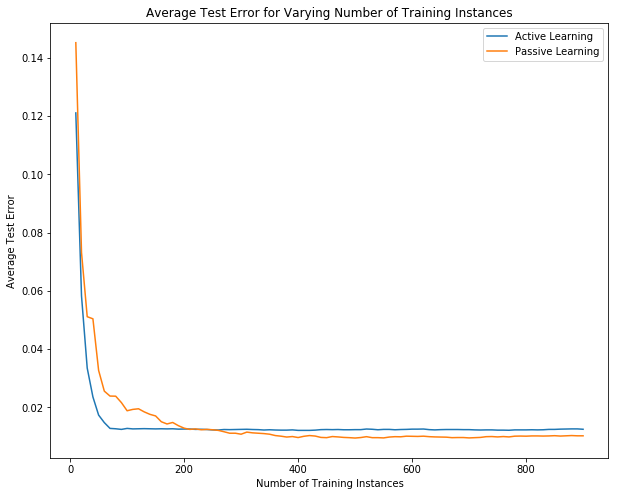

In [1105]:
plt.figure(figsize=(10,8))
plt.plot(active_mean_df, label='Active Learning')
plt.plot(passive_mean_df, label='Passive Learning')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.title('Average Test Error for Varying Number of Training Instances')
plt.legend(loc='upper right')
plt.show()

For both passive and active learning, the test error decreases suddenly then slowly decreases and plateaus as the number of training isntances increases. Active learning performs better than passive learning as the average test error decreases at a much quicker rate. The plot for active learning is also much smoother than passive learning. 